# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way which conbines unsupervised and supervised method. The baselines are the methods to train the model with supervised categories. The unsupervised section follows. The primary goal is to train a model that is able to classify all the categories (labeled and unlabeled).

A classification model is trained under labeled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. They are Kmeans, Kmeans with PCA, Kmeans with Auto Encoder, Gaussian Mixture, Gaussian Mixture with PCA and Gaussian Mixture with Auto Encoder. These unlabeled categories will be labeled by the clustering methods and concatenated with other categories. The classification model will be trained again on the full dataset which contains the pre-labeled categories and new categories just labeled by the unsupervised methods. The result of the classification is drawn between all eight methods and an conclusion is given at the end.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

### Library
Several library functions are implemented. They are imported in the front of the next code block. The externel libraries are imported in the behind of the next block.

Our own code library is called mylib implemented 
pip install lightning-bolts

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 30
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    global mode_metrics
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    mode_metrics[mode] = eval_metrics


## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.6005 Accuracy: 0.7876 F1_score: 0.7845
	Validation - Loss: 0.4410 Accuracy: 0.8402 F1_score: 0.8378
Epoch: 2
	Train      - Loss: 0.4169 Accuracy: 0.8498 F1_score: 0.8486
	Validation - Loss: 0.3924 Accuracy: 0.8614 F1_score: 0.8612
Epoch: 3
	Train      - Loss: 0.3747 Accuracy: 0.8629 F1_score: 0.8620
	Validation - Loss: 0.3723 Accuracy: 0.8674 F1_score: 0.8671
Epoch: 4
	Train      - Loss: 0.3476 Accuracy: 0.8744 F1_score: 0.8737
	Validation - Loss: 0.3546 Accuracy: 0.8740 F1_score: 0.8731
Epoch: 5
	Train      - Loss: 0.3268 Accuracy: 0.8811 F1_score: 0.8804
	Validation - Loss: 0.3470 Accuracy: 0.8760 F1_score: 0.8739
Epoch: 6
	Train      - Loss: 0.3114 Accuracy: 0.8883 F1_score: 0.8877
	Validation - Loss: 0.3339 Accuracy: 0.8764 F1_score: 0.8765
Epoch: 7
	Train      - Loss: 0.2976 Accuracy: 0.8934 F1_score: 0.8929
	Validation - Loss: 0.3294 Accuracy: 0.8800 F1_sc

<Figure size 432x288 with 0 Axes>

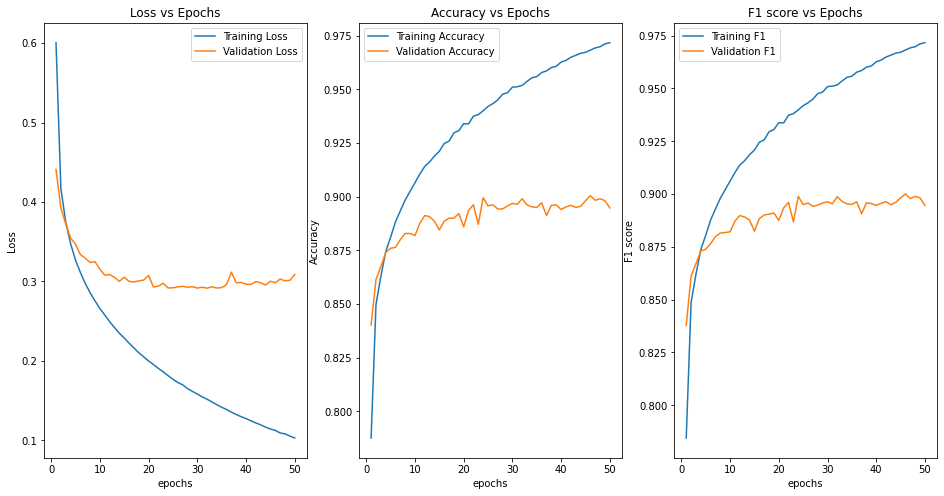

Loading model at epoch 46 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3412 Accuracy: 0.8870 F1_score: 0.8865
Result on unlabelled test set: Loss: 9.8867 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.2022 Accuracy: 0.6209 F1_score: 0.5369


In [5]:
whole_flow(6, False)

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5406 Accuracy: 0.8199 F1_score: 0.8184
	Validation - Loss: 0.3843 Accuracy: 0.8648 F1_score: 0.8641
Epoch: 2
	Train      - Loss: 0.3562 Accuracy: 0.8748 F1_score: 0.8741
	Validation - Loss: 0.3357 Accuracy: 0.8813 F1_score: 0.8805
Epoch: 3
	Train      - Loss: 0.3128 Accuracy: 0.8902 F1_score: 0.8896
	Validation - Loss: 0.3229 Accuracy: 0.8870 F1_score: 0.8867
Epoch: 4
	Train      - Loss: 0.2857 Accuracy: 0.9004 F1_score: 0.9000
	Validation - Loss: 0.2982 Accuracy: 0.8965 F1_score: 0.8964
Epoch: 5
	Train      - Loss: 0.2651 Accuracy: 0.9071 F1_score: 0.9067
	Validation - Loss: 0.2899 Accuracy: 0.8993 F1_score: 0.8987
Epoch: 6
	Train      - Loss: 0.2491 Accuracy: 0.9127 F1_score: 0.9123
	Validation - Loss: 0.2813 Accuracy: 0.9002 F1_score: 0.8991
Epoch: 7
	Train      - Loss: 0.2358 Accuracy: 0.9181 F1_score: 0.9178
	Validation - Loss: 0.2730 Accuracy: 0.9042 F

<Figure size 432x288 with 0 Axes>

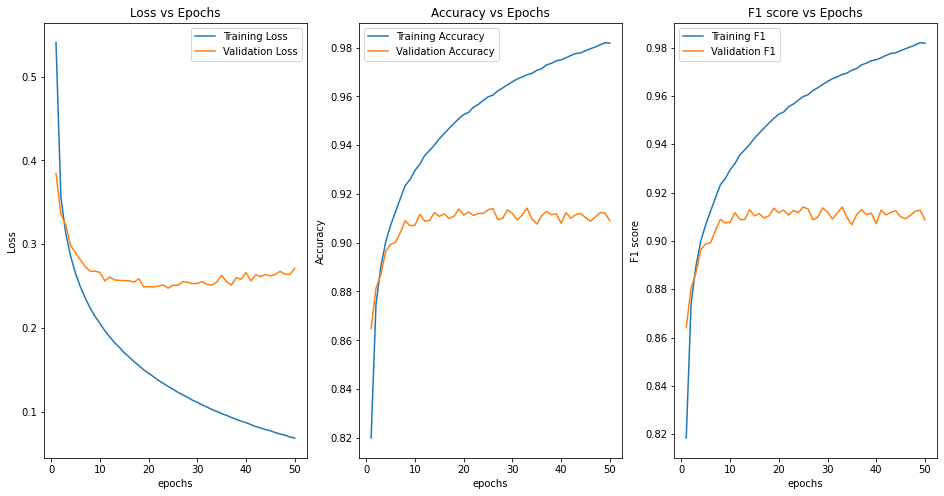

Loading model at epoch 25 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3675 Accuracy: 0.8797 F1_score: 0.8831
Result on unlabelled test set: Loss: 0.0977 Accuracy: 0.9713 F1_score: 0.9769
Result on full test set      : Loss: 0.2875 Accuracy: 0.9072 F1_score: 0.9067


In [6]:
whole_flow(7, False)

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8801111111111111
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5376 Accuracy: 0.8180 F1_score: 0.8162
	Validation - Loss: 0.3720 Accuracy: 0.8680 F1_score: 0.8668
Epoch: 2
	Train      - Loss: 0.3586 Accuracy: 0.8746 F1_score: 0.8738
	Validation - Loss: 0.3227 Accuracy: 0.8850 F1_score: 0.8836
Epoch: 3
	Train      - Loss: 0.3171 Accuracy: 0.8889 F1_score: 0.8883
	Validation - Loss: 0.2998 Accuracy: 0.8937 F1_score: 0.8908
Epoch: 4
	Train      - Loss: 0.2917 Accuracy: 0.8980 F1_score: 0.8976
	Validation - Loss: 0.2858 Accuracy: 0.8970 F1_score: 0.8952
Epoch: 5
	Train      - Loss: 0.2721 Accuracy: 0.9061 F1_score: 0.9057
	Validation - Loss: 0.2694 Accuracy: 0.9047 F1_score: 0.9039
Epoch: 6
	Train      - Loss: 0.2567 Accuracy: 0.9113 F1_score: 0.9110
	Validation - Loss: 0.2651 Accuracy: 0.9057 F1_score: 0.9063
Epoch: 7
	Train      - Loss: 0.2431 Accuracy: 0.9166 F1_s

<Figure size 432x288 with 0 Axes>

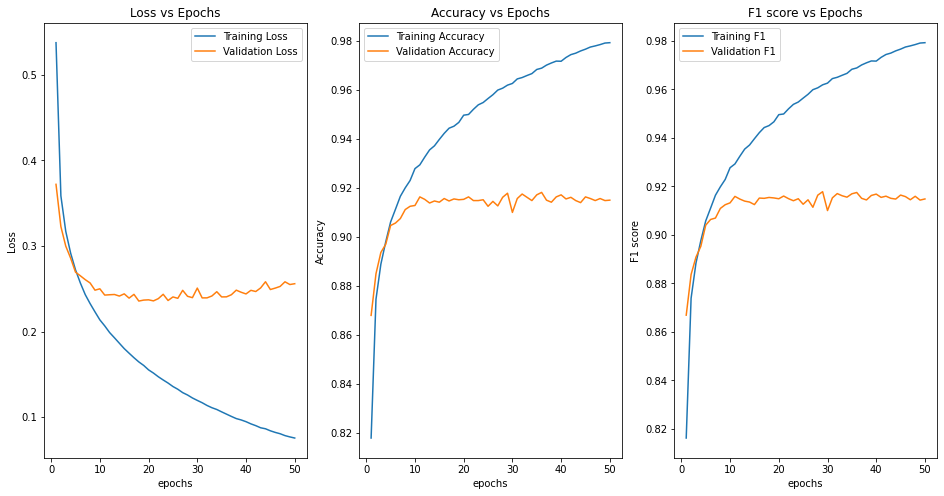

Loading model at epoch 29 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3607 Accuracy: 0.8836 F1_score: 0.8874
Result on unlabelled test set: Loss: 0.7630 Accuracy: 0.8817 F1_score: 0.8890
Result on full test set      : Loss: 0.4809 Accuracy: 0.8830 F1_score: 0.8835


In [7]:
whole_flow(0, False)

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.8808888888888889
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5444 Accuracy: 0.8170 F1_score: 0.8146
	Validation - Loss: 0.3965 Accuracy: 0.8607 F1_score: 0.8610
Epoch: 2
	Train      - Loss: 0.3661 Accuracy: 0.8700 F1_score: 0.8691
	Validation - Loss: 0.3495 Accuracy: 0.8743 F1_score: 0.8746
Epoch: 3
	Train      - Loss: 0.3233 Accuracy: 0.8862 F1_score: 0.8855
	Validation - Loss: 0.3248 Accuracy: 0.8853 F1_score: 0.8857
Epoch: 4
	Train      - Loss: 0.2961 Accuracy: 0.8964 F1_score: 0.8957
	Validation - Loss: 0.3125 Accuracy: 0.8898 F1_score: 0.8905
Epoch: 5
	Train      - Loss: 0.2764 Accuracy: 0.9036 F1_score: 0.9031
	Validation - Loss: 0.2965 Accuracy: 0.8905 F1_score: 0.8900
Epoch: 6
	Train      - Loss: 0.2606 Accuracy: 0.9099 F1_score: 0.9095
	Validation - Loss: 0.2860 Accuracy: 0.9003 F1_score: 0.8997
Epoch: 7
	Train      - Loss: 0.2473 Accuracy: 0.

<Figure size 432x288 with 0 Axes>

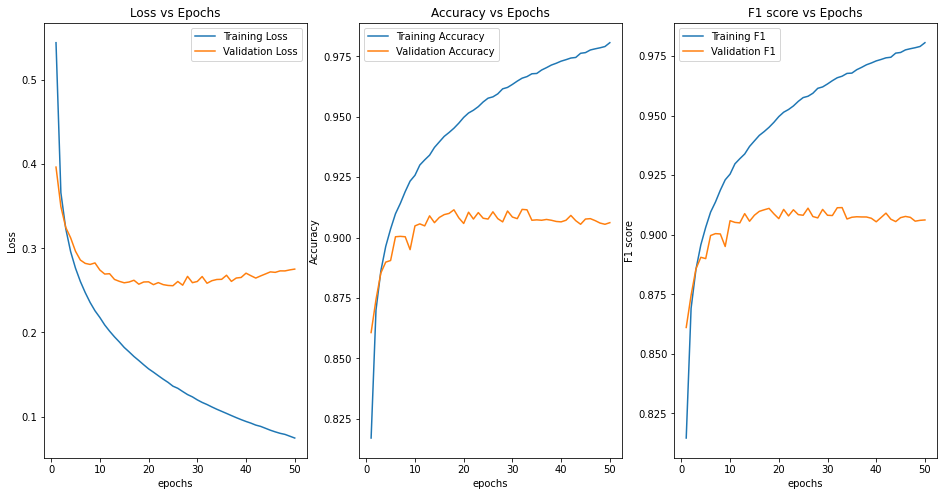

Loading model at epoch 33 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3762 Accuracy: 0.8799 F1_score: 0.8837
Result on unlabelled test set: Loss: 0.8102 Accuracy: 0.8757 F1_score: 0.8843
Result on full test set      : Loss: 0.5039 Accuracy: 0.8786 F1_score: 0.8791


In [8]:
whole_flow(1, False)

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': 0.49883280908870864}
Epoch: 2 Loss: {'loss': 0.43757993258125616}
Epoch: 3 Loss: {'loss': 0.41114585305403645}
Epoch: 4 Loss: {'loss': 0.40090878622781745}
Epoch: 5 Loss: {'loss': 0.39582062948025354}
Epoch: 6 Loss: {'loss': 0.3912171424493908}
Epoch: 7 Loss: {'loss': 0.3878973717693749}
Epoch: 8 Loss: {'loss': 0.3848714706741048}
Epoch: 9 Loss: {'loss': 0.3829218999848273}
Epoch: 10 Loss: {'loss': 0.3806251947028599}
Epoch: 11 Loss: {'loss': 0.3794674489045016}
Epoch: 12 Loss: {'loss': 0.3774254018735293}
Epoch: 13 Loss: {'loss': 0.3761101437080817}
Epoch: 14 Loss: {'loss': 0.3747841378617668}
Epoch: 15 Loss: {'loss': 0.37346694974450406}
Labeling accuracy: 0.33766666666666667
Start Training... Net
Epoch: 1
	Train      - Loss: 0.8508 Accuracy: 0.6476 F1_score: 0.6324
	Validation - Loss: 0.7474 Accuracy: 0.6878 F1_score: 0.6

<Figure size 432x288 with 0 Axes>

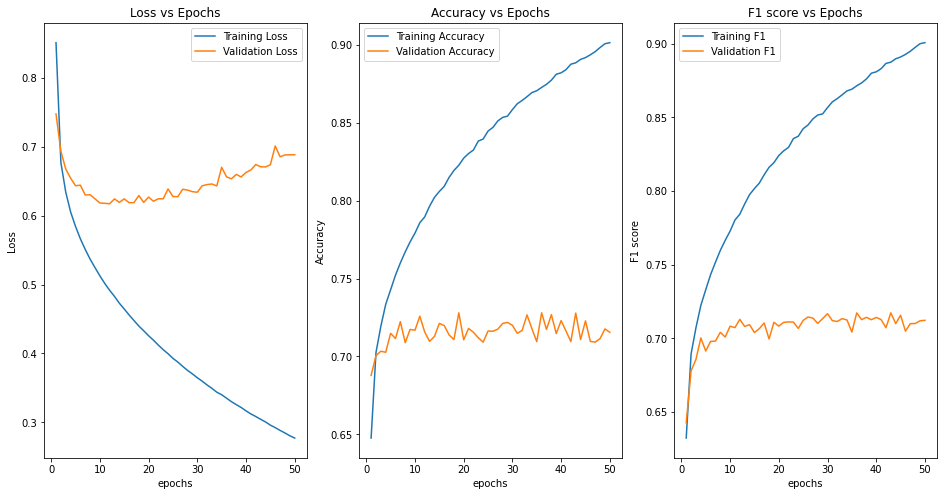

Loading model at epoch 43 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3760 Accuracy: 0.8777 F1_score: 0.8805
Result on unlabelled test set: Loss: 1.4242 Accuracy: 0.3317 F1_score: 0.3225
Result on full test set      : Loss: 0.6898 Accuracy: 0.7139 F1_score: 0.7097


In [9]:
whole_flow(2, False)

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8389444444444445
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5441 Accuracy: 0.8199 F1_score: 0.8177
	Validation - Loss: 0.4012 Accuracy: 0.8562 F1_score: 0.8536
Epoch: 2
	Train      - Loss: 0.3568 Accuracy: 0.8749 F1_score: 0.8741
	Validation - Loss: 0.3558 Accuracy: 0.8733 F1_score: 0.8726
Epoch: 3
	Train      - Loss: 0.3147 Accuracy: 0.8892 F1_score: 0.8885
	Validation - Loss: 0.3325 Accuracy: 0.8842 F1_score: 0.8834
Epoch: 4
	Train      - Loss: 0.2881 Accuracy: 0.8990 F1_score: 0.8985
	Validation - Loss: 0.3176 Accuracy: 0.8885 F1_score: 0.8882
Epoch: 5
	Train      - Loss: 0.2673 Accuracy: 0.9077 F1_score: 0.9073
	Validation - Loss: 0.3052 Accuracy: 0.8892 F1_score: 0.8883
Epoch: 6
	Train      - Loss: 0.2513 Accuracy: 0.9126 F1_score: 0.9122
	Validation - Loss: 0.2983 Accuracy: 0.8927 F1_score: 0.8928
Epoch: 7
	Train      - Loss: 0.2381 Accuracy: 0

<Figure size 432x288 with 0 Axes>

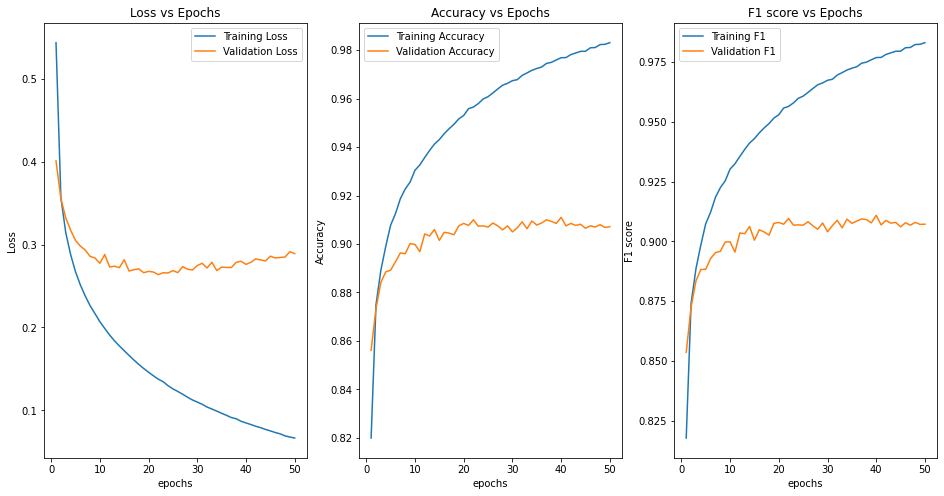

Loading model at epoch 40 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3690 Accuracy: 0.8807 F1_score: 0.8859
Result on unlabelled test set: Loss: 1.4020 Accuracy: 0.8303 F1_score: 0.8325
Result on full test set      : Loss: 0.6786 Accuracy: 0.8656 F1_score: 0.8653


In [10]:
whole_flow(3, False)

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.6936666666666667
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5527 Accuracy: 0.8107 F1_score: 0.8084
	Validation - Loss: 0.4079 Accuracy: 0.8507 F1_score: 0.8456
Epoch: 2
	Train      - Loss: 0.3678 Accuracy: 0.8712 F1_score: 0.8704
	Validation - Loss: 0.3470 Accuracy: 0.8740 F1_score: 0.8735
Epoch: 3
	Train      - Loss: 0.3235 Accuracy: 0.8859 F1_score: 0.8853
	Validation - Loss: 0.3218 Accuracy: 0.8835 F1_score: 0.8836
Epoch: 4
	Train      - Loss: 0.2955 Accuracy: 0.8961 F1_score: 0.8957
	Validation - Loss: 0.3048 Accuracy: 0.8895 F1_score: 0.8899
Epoch: 5
	Train      - Loss: 0.2750 Accuracy: 0.9039 F1_score: 0.9035
	Validation - Loss: 0.2982 Accuracy: 0.8917 F1_score: 0.8909
Epoch: 6
	Train      - Loss: 0.2589 Accuracy: 0.9108 F1_score: 0.9105
	Validation - Loss: 0.2886 Accuracy: 0.8925 F1_score: 0.8918
Epoch: 7
	Train      - Loss: 0.2454 Ac

<Figure size 432x288 with 0 Axes>

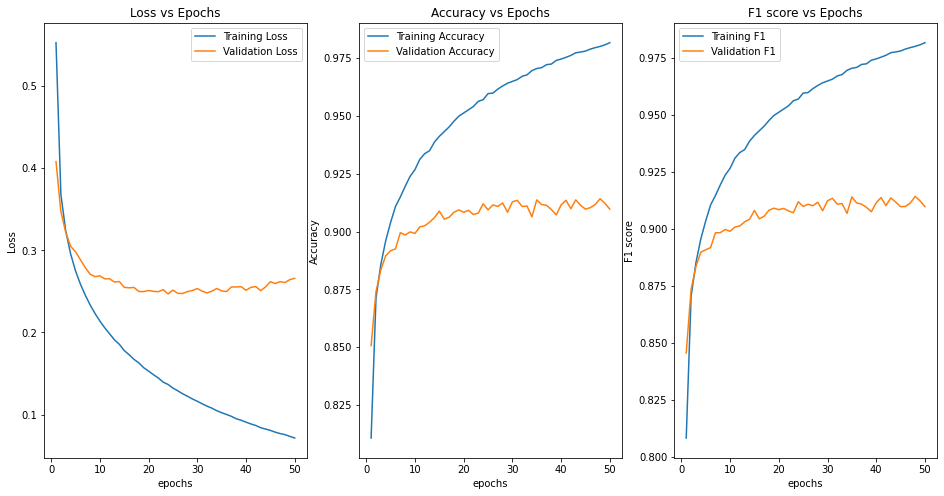

Loading model at epoch 48 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3577 Accuracy: 0.8793 F1_score: 0.8824
Result on unlabelled test set: Loss: 3.7369 Accuracy: 0.6930 F1_score: 0.6829
Result on full test set      : Loss: 1.3760 Accuracy: 0.8234 F1_score: 0.8189


In [11]:
whole_flow(4, False)

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 5: clustering: Gaussian Mixture with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': 0.4987054119419247}
Epoch: 2 Loss: {'loss': 0.4339229750908501}
Epoch: 3 Loss: {'loss': 0.4082414620087795}
Epoch: 4 Loss: {'loss': 0.3999502856290997}
Epoch: 5 Loss: {'loss': 0.39393196086900484}
Epoch: 6 Loss: {'loss': 0.3898146413994513}
Epoch: 7 Loss: {'loss': 0.3865662428350262}
Epoch: 8 Loss: {'loss': 0.3842445638421162}
Epoch: 9 Loss: {'loss': 0.381816762961037}
Epoch: 10 Loss: {'loss': 0.3794039122058909}
Epoch: 11 Loss: {'loss': 0.37797658253944155}
Epoch: 12 Loss: {'loss': 0.3763511635588075}
Epoch: 13 Loss: {'loss': 0.37518851271107606}
Epoch: 14 Loss: {'loss': 0.3736722849931429}
Epoch: 15 Loss: {'loss': 0.3726033934162099}
Labeling accuracy: 0.3405
Start Training... Net
Epoch: 1
	Train      - Loss: 0.8111 Accuracy: 0.7137 F1_score: 0.6722
	Validation - Loss: 0.6940 Accuracy: 0.7495 F1_score: 0.7046
Epo

<Figure size 432x288 with 0 Axes>

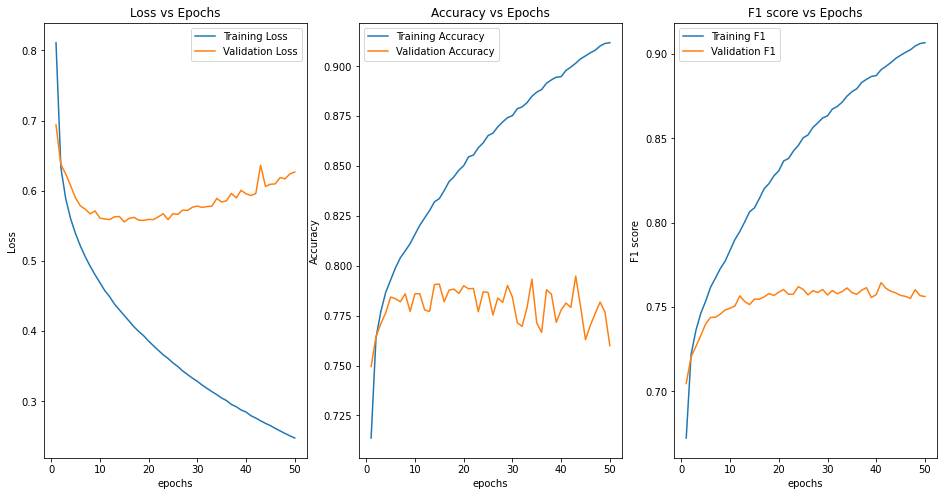

Loading model at epoch 41 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3703 Accuracy: 0.8797 F1_score: 0.8833
Result on unlabelled test set: Loss: 1.6187 Accuracy: 0.3320 F1_score: 0.3043
Result on full test set      : Loss: 0.7450 Accuracy: 0.7154 F1_score: 0.7063


In [12]:
whole_flow(5, False)

<Figure size 432x288 with 0 Axes>

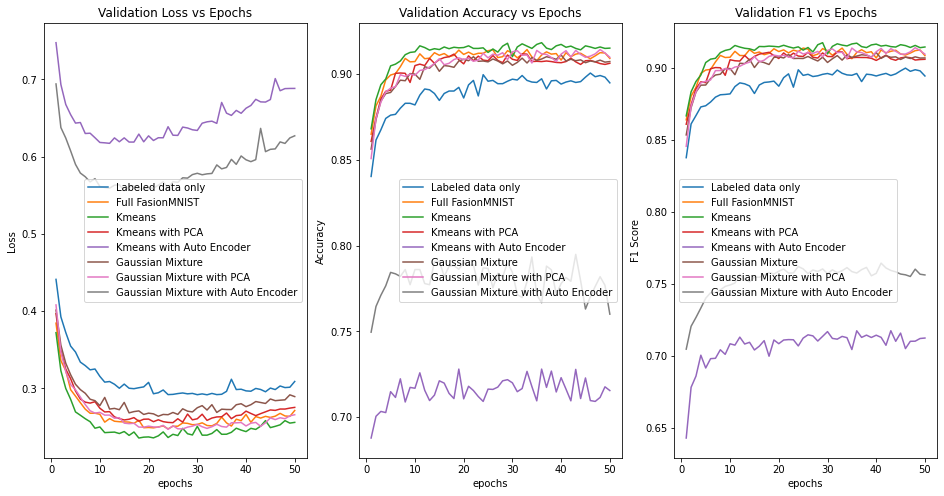

In [13]:
report_summary(mode_metrics, mode_description_short)

## Conclusion